# Analysis of memory-pool simulations

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

## Adversarial nodes

### Read data

In [2]:
adversaries <- fread("adversaries.tsv.gz", stringsAsFactors=TRUE)
adversaries %>% summary

 Adversarial nodes    Block ID         Txs          Honest txs   
 Min.   :  0.0     B0     : 101   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:120.0     B1     : 101   1st Qu.:60.00   1st Qu.:54.00  
 Median :250.0     B10    : 101   Median :60.00   Median :59.00  
 Mean   :249.2     B11    : 101   Mean   :52.25   Mean   :50.89  
 3rd Qu.:375.0     B12    : 101   3rd Qu.:60.00   3rd Qu.:60.00  
 Max.   :500.0     B13    : 101   Max.   :60.00   Max.   :60.00  
                   (Other):6104                                  
 Adversarial txs 
 Min.   : 0.000  
 1st Qu.: 0.000  
 Median : 1.000  
 Mean   : 1.351  
 3rd Qu.: 2.000  
 Max.   :35.000  
                 

### Raw data at the block level

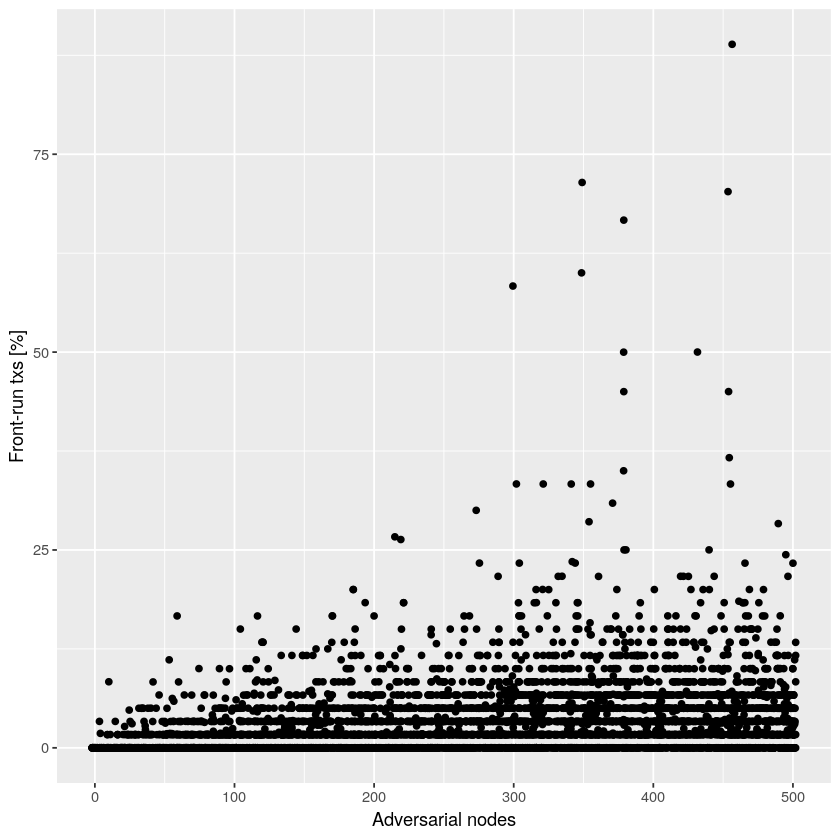

In [3]:
ggplot(
    adversaries[
        `Txs` > 0,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`, `Block ID`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_jitter()

### Trends

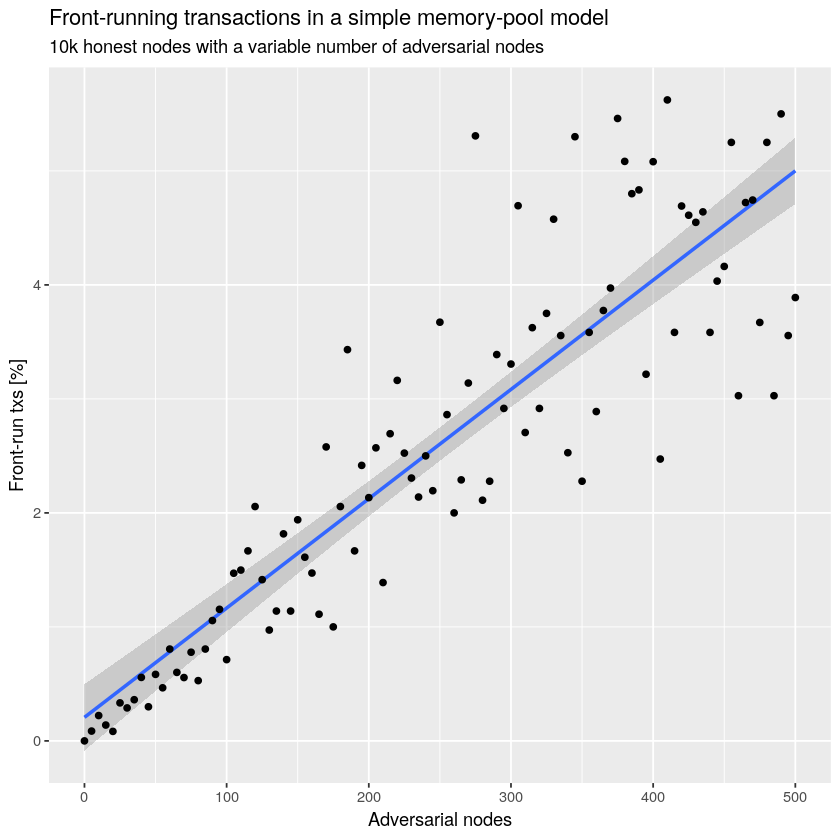

In [4]:
ggplot(
    adversaries[
        ,
        .(`Front-run txs [%]`=100*sum(`Adversarial txs`)/sum(`Txs`)),
        .(`Adversarial nodes`)
    ], 
    aes(x=`Adversarial nodes`, y=`Front-run txs [%]`)
) +
    geom_smooth(formula=y~x, method="lm") +
    geom_point() +
    ggtitle(
        "Front-running transactions in a simple memory-pool model",
        "10k honest nodes with a variable number of adversarial nodes"
    )

In [5]:
ggsave("adversarial-scatter.png", units="in", dpi=150, width=8, height=6)

In [6]:
ggsave("adversarial-scatter.svg", units="in", dpi=150, width=8, height=6)

## Mempool fragmentation

### Read data file

In [7]:
fragmentation <- fread("fragmentation.tsv.gz", stringsAsFactors=TRUE)
fragmentation %>% summary

     Trial          Time [s]       Node ID                TxId           
 Min.   : 1.00   Min.   :   0   H1548  :    142504   T239   :    722458  
 1st Qu.: 5.00   1st Qu.: 317   H2143  :    142504   T265   :    712835  
 Median :10.00   Median : 612   H4477  :    142504   T2328  :    687258  
 Mean   :10.48   Mean   : 621   H5389  :    142504   T1817  :    672636  
 3rd Qu.:15.00   3rd Qu.: 917   H9535  :    142504   T1697  :    669803  
 Max.   :20.00   Max.   :1478   H1070  :    142503   T1335  :    667701  
                                (Other):1424076281   (Other):1420798613  

### Fragmentation over time and memory pool size

In [8]:
abstract <- melt(
    fragmentation[
        , 
        .(`Nodes`=.N), 
        .(`Trial`, `Time [s]`, `TxId`)
    ][
        ,
        .(
            `Minimum`=min(`Nodes`)%>%as.numeric,
            `Mean`=mean(`Nodes`),
            `Maximum`=max(`Nodes`)%>%as.numeric,
            `Txs`=length(unique(`TxId`))
        ),
        .(`Trial`, `Time [s]`)
    ],
    id.vars=c("Trial", "Time [s]", "Txs"),
    variable.name="Statistic",
    value.name="Number of nodes with tx in mempool"
)

#### Plot by time (linear smoothing)

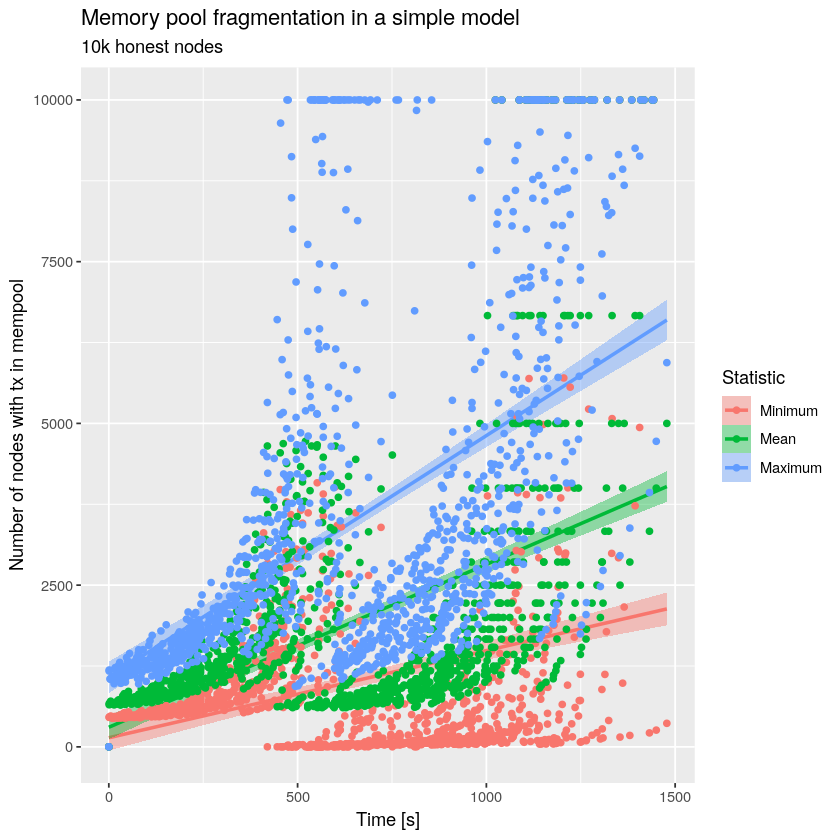

In [9]:
ggplot(
    abstract,
    aes(x=`Time [s]`, y=`Number of nodes with tx in mempool`, color=`Statistic`, fill=`Statistic`)
) +
    geom_smooth(formula=y~x, method="lm") +
    geom_point() +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    )

#### Plot by time (loess smoothing)

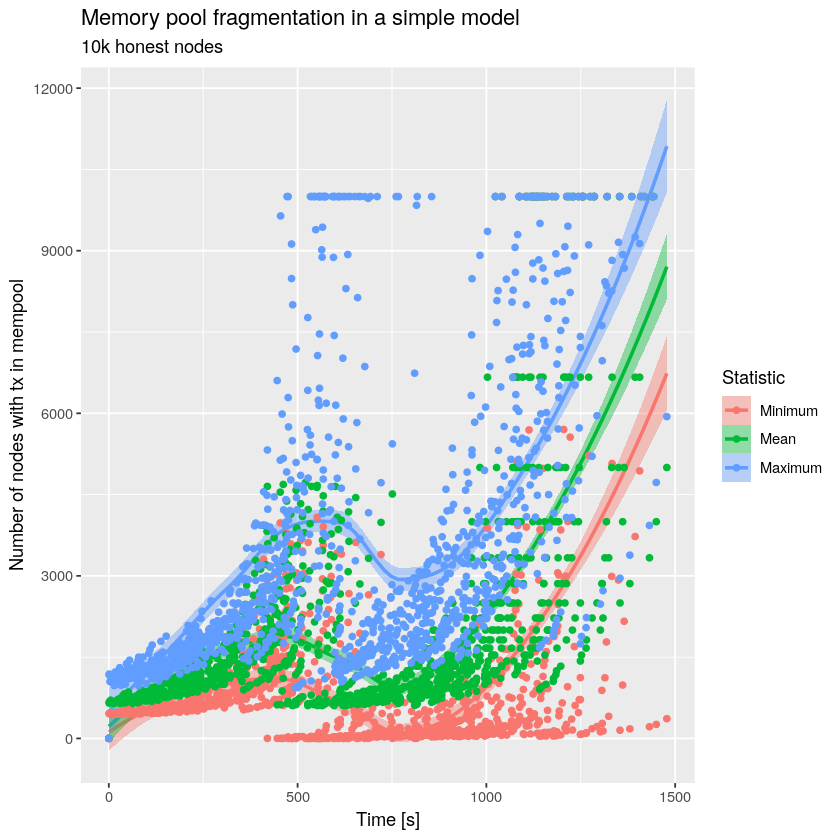

In [10]:
ggplot(
    abstract,
    aes(x=`Time [s]`, y=`Number of nodes with tx in mempool`, color=`Statistic`, fill=`Statistic`)
) +
    geom_smooth(formula=y~x, method="loess") +
    geom_point() +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    )

#### Plot by number of transactions in memory pool (linear smoothing)

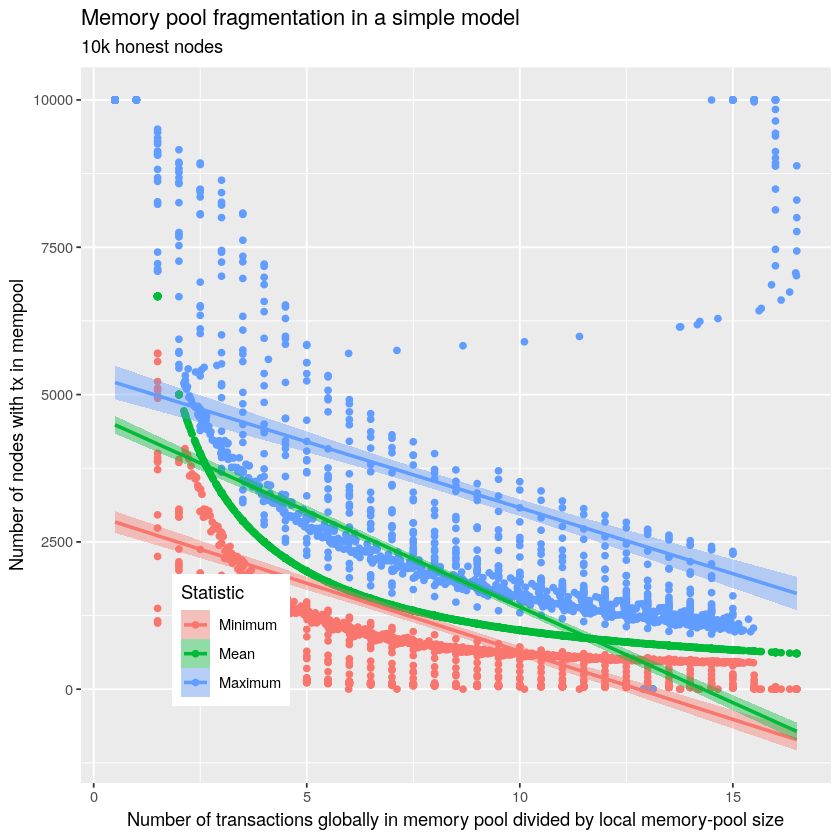

In [11]:
ggplot(
    abstract,
    aes(x=`Txs`/120, y=`Number of nodes with tx in mempool`, color=`Statistic`, fill=`Statistic`)
) +
    geom_point() +
    geom_smooth(formula=y~x, method="lm") +
    xlab("Number of transactions globally in memory pool divided by local memory-pool size") +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    ) +
    theme(legend.position=c(0.2, 0.2))

#### Plot by number of transactions in memory pool (loess smoothing)

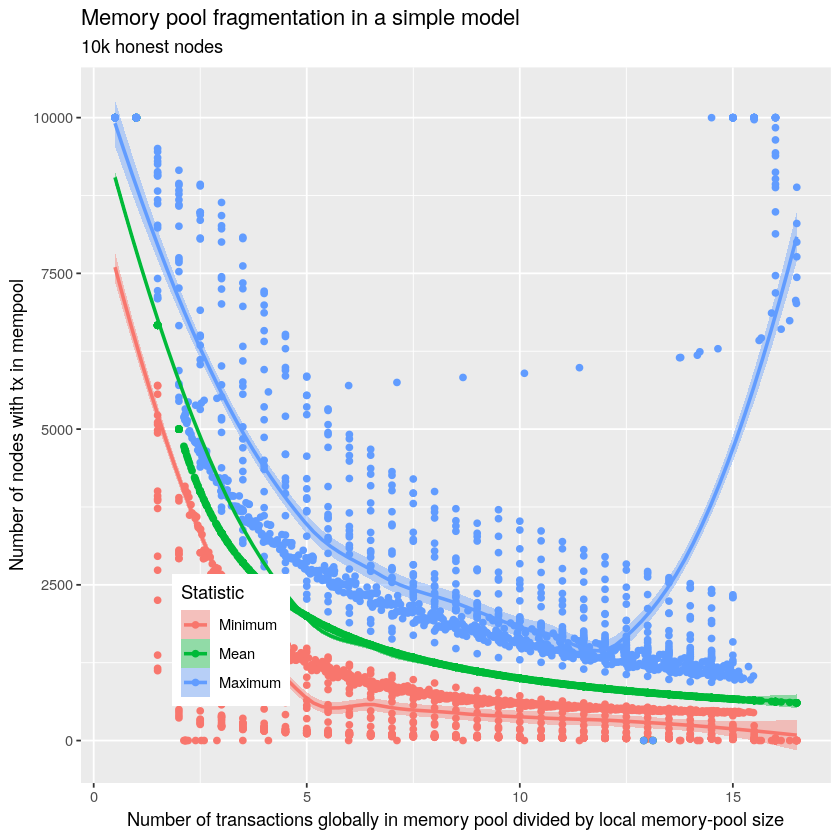

In [12]:
ggplot(
    abstract,
    aes(x=`Txs`/120, y=`Number of nodes with tx in mempool`, color=`Statistic`, fill=`Statistic`)
) +
    geom_point() +
    geom_smooth(formula=y~x, method="loess") +
    xlab("Number of transactions globally in memory pool divided by local memory-pool size") +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    ) +
    theme(legend.position=c(0.2, 0.2))

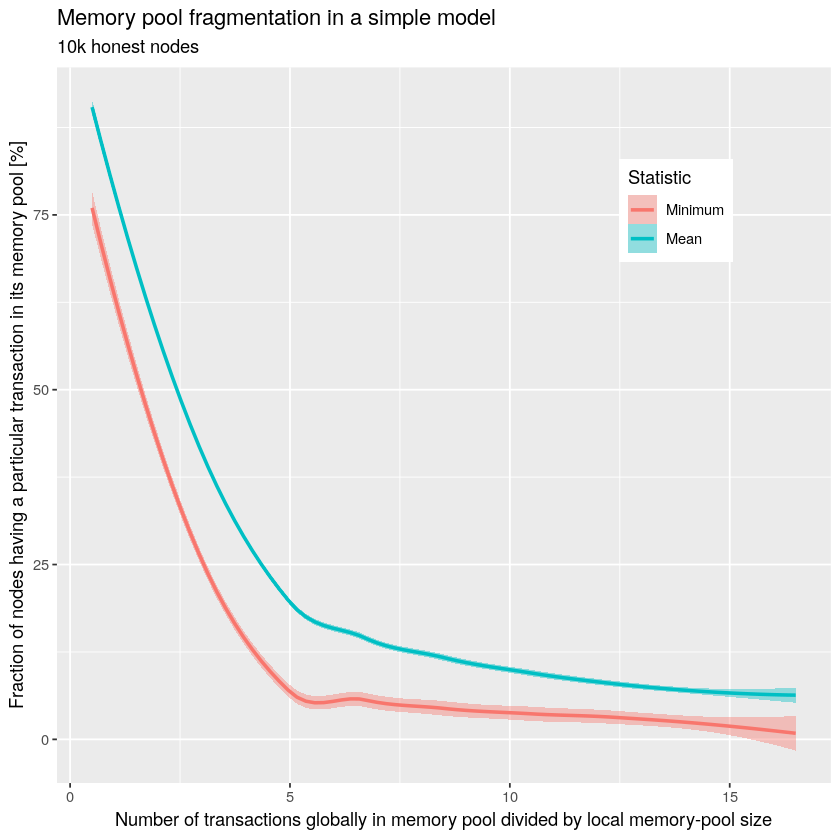

In [13]:
ggplot(
    abstract[`Statistic` != "Maximum"],
    aes(x=`Txs`/120, y=`Number of nodes with tx in mempool`/100, color=`Statistic`, fill=`Statistic`)
) +
    geom_smooth(formula=y~x, method="loess") +
    scale_y_continuous(breaks=c(0, 25, 50, 75, 100)) +
    xlab("Number of transactions globally in memory pool divided by local memory-pool size") +
    ylab("Fraction of nodes having a particular transaction in its memory pool [%]") +
    ggtitle(
        "Memory pool fragmentation in a simple model",
        "10k honest nodes"
    ) +
    theme(legend.position=c(0.8,0.8))

In [14]:
ggsave("fragmentation-load-loess.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("fragmentation-load-loess.svg", units="in", dpi=150, width=8, height=6)